In [1]:
import matplotlib.pyplot as plt
import holopy as hp
from holopy.scattering import Scatterer, Sphere, calc_holo, calc_field, Spheres, Ellipsoid
from holopy.scattering.theory import Lens, DDA
from holopy.core.utils import ensure_array
import numpy as np
import scipy as sp
import pandas as pd
from scipy import interpolate
import skimage.transform
import gc, os
from tqdm import tqdm

In [2]:
import newsdm_utils

In [7]:
from holopy.scattering.theory.backscatter import Backscattered
from holopy.sandbox.newsdm_utils import *

## Brightness peak

In [3]:
Ag_n = np.loadtxt('Ag_wu14.txt')
lamb_min = Ag_n[0,0]; lamb_max = Ag_n[-1,0]
m_ag = {}
m_ag['R'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,1], kind='cubic')
m_ag['I'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,2], kind='cubic')
#mask = (ag_n[:,0]>0.35) & (ag_n[:,0]<0.65)
#ag_mask = ag_n[mask]

In [4]:
peak_sph = {}

100nm: 100%|██████████| 45/45 [46:00<00:00, 61.35s/it]


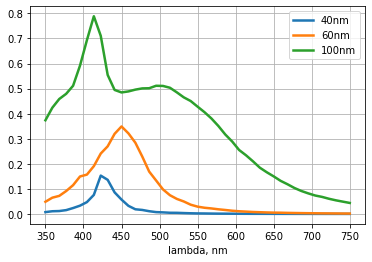

CPU times: user 21min 41s, sys: 1min 22s, total: 23min 4s
Wall time: 1h 1min 10s


In [5]:
%%time
#ell = Ellipsoid(n = 0.05+1j*2.1, r = (0.05,0.025,0.025), center = (0.5,0.5,0))
for d in [40,60,100]:
    len_dda = Lens(1.38, DDA(max_dpl_size=0.002, use_gpu=True))
    detector = hp.detector_grid(100, .01)

    peak_sph[str(d)] = []
    for lam in tqdm(np.linspace(0.35,0.75,45), desc=str(d)+'nm'):
        s_a = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0.5,0.5,0))
        holo = calc_field(detector, s_a, medium_index=1.515, illum_wavelen=lam, illum_polarization=(1,0), theory=len_dda) #np.linspace(0.42,0.48,5)
        holo = (np.abs(holo)**2).sum(dim='vector')
        peak_sph[str(d)].append(holo.max())
    plt.plot(np.linspace(0.35,0.75,45)*1000, peak_sph[str(d)], label=str(d)+'nm', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.show()

In [33]:
peak_sph_num = pd.DataFrame({name:np.array(list(map(lambda x: x.values ,peak_sph[name]))) for name in peak_sph.columns})
peak_sph_num.to_csv('cdr/Ag_sph_peaks.csv')

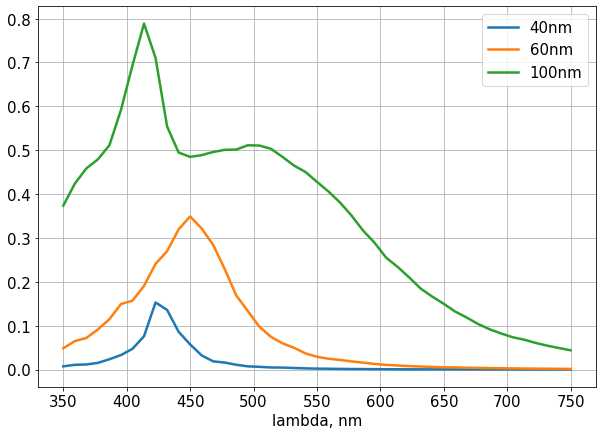

In [8]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
for d in [40,60,100]:
    plt.plot(np.linspace(0.35,0.75,45)*1000, peak_sph[str(d)], label=str(d)+'nm', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.savefig('cdr/adda_sph_ag.png')
plt.show()

* Dielectric sphere

60nm:   0%|          | 0/40 [00:00<?, ?it/s]

5.099341881376617e-05


100nm:   0%|          | 0/40 [00:00<?, ?it/s]

0.000615958900892309


100nm: 100%|██████████| 40/40 [07:58<00:00, 11.97s/it]

0.015027002681183574


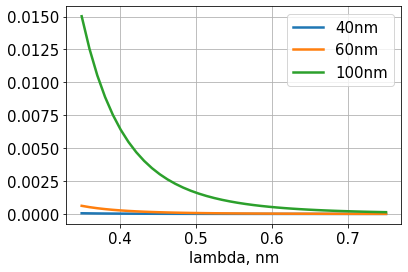

CPU times: user 19min 12s, sys: 1min 11s, total: 20min 23s
Wall time: 12min 57s


In [9]:
%%time
len_dda = Lens(1.38, DDA(max_dpl_size=0.002))
detector = hp.detector_grid(100, .01)
peak_diel = {}
for d in [40,60,100]:
    peak_diel[d] = []
    for lam in tqdm(np.linspace(0.35,0.75,40), desc=str(d)+'nm'):
        s_a = Sphere(n = 1.515, r = d/2*1e-3, center = (0.5,0.5,0))
        holo = calc_field(detector, s_a, medium_index=1., illum_wavelen=lam, illum_polarization=(1,0), theory=len_dda) #np.linspace(0.42,0.48,5)
        holo = (np.abs(holo)**2).sum(dim='vector')
        peak_diel[d].append(holo.max())
    plt.plot(np.linspace(0.35,0.75,40), np.array(peak_diel[d]), label=str(d)+'nm', linewidth=2.5)
    print(np.max(peak_diel[d]))
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.show()

In [34]:
peak_diel_num = pd.DataFrame({name:np.array(list(map(lambda x: x.values ,peak_diel[name]))) for name in peak_diel.columns})
peak_diel_num.to_csv('cdr/diel_sph_peaks.csv')

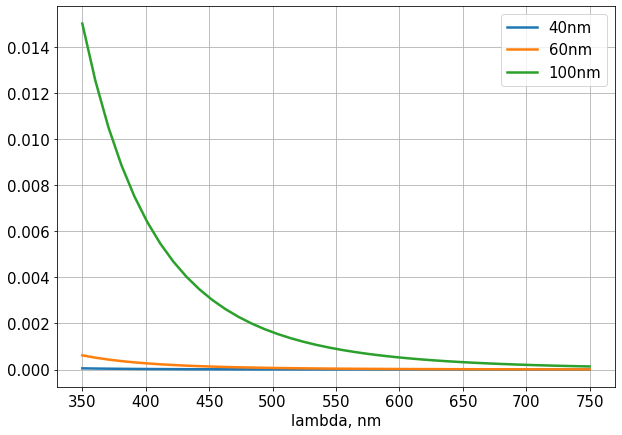

In [12]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
for d in [40,60,100]:
    plt.plot(np.linspace(0.35,0.75,40)*1000, peak_diel[d], label=str(d)+'nm', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.savefig('cdr/adda_sph_diel.png')
plt.show()

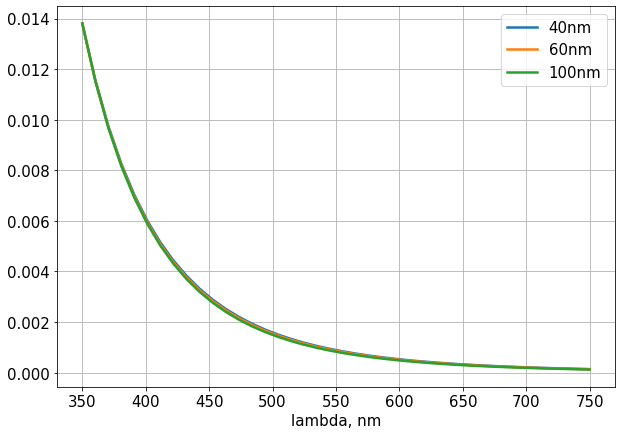

In [35]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
for d in [40,60,100]:
    plt.plot(np.linspace(0.35,0.75,40)*1000, peak_diel_num[d]*0.0138/np.max(peak_diel_num[d]), label=str(d)+'nm', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.savefig('cdr/adda_sph_diel_scaled.png')
plt.show()

## Ellipsoid peak

In [36]:
Ag_n = np.loadtxt('Ag_wu14.txt')
lamb_min = Ag_n[0,0]; lamb_max = Ag_n[-1,0]
m_ag = {}
m_ag['R'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,1])#, kind='cubic')
m_ag['I'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,2])#, kind='cubic')
#mask = (ag_n[:,0]>0.35) & (ag_n[:,0]<0.65)
#ag_mask = ag_n[mask]

100%|██████████| 45/45 [14:19<00:00, 19.10s/it]


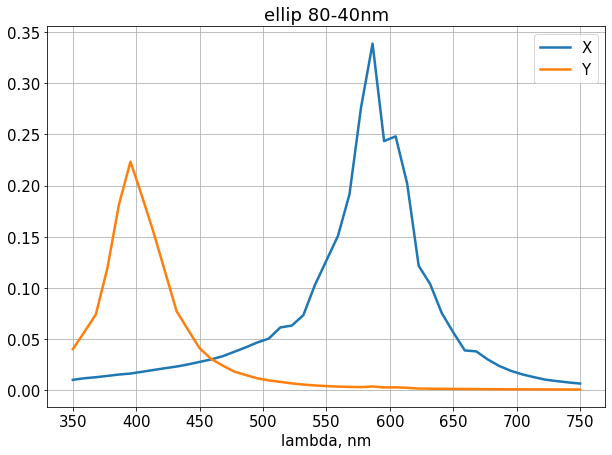

CPU times: user 15min 31s, sys: 1min 41s, total: 17min 13s
Wall time: 14min 19s


In [37]:
%%time
#ell = Ellipsoid(n = 0.05+1j*2.1, r = (0.05,0.025,0.025), center = (0.5,0.5,0))
d = 40
detector = hp.detector_grid(100, .01)

peak_el = [[],[]]
for lam in tqdm(np.linspace(0.35,0.75,45)):
    len_dda = Lens(1.38, DDA(max_dpl_size=0.002, use_gpu=True))
    s_a = Ellipsoid(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = (d*1e-3,d/2*1e-3,d/2*1e-3), center = (0.5,0.5,0))
    holo = calc_field(detector, s_a, medium_index=1.515, illum_wavelen=lam, illum_polarization=(1,0), theory=len_dda) #np.linspace(0.42,0.48,5)
    holo = (np.abs(holo)**2).sum(dim='vector')
    peak_el[0].append(holo.max())
    
    len_dda = Lens(1.38, DDA(use_gpu=True, max_dpl_size=0.002, addacmd=['-orient','90','0','0']))
    holo = calc_field(detector, s_a, medium_index=1.515, illum_wavelen=lam, illum_polarization=(1,0), theory=len_dda)
    holo = (np.abs(holo)**2).sum(dim='vector')
    peak_el[1].append(holo.max())
    #holo = calc_field(detector, s_a, medium_index=1.515, illum_wavelen=lam, illum_polarization=(0,1), theory=len_dda) #np.linspace(0.42,0.48,5)
    #holo = (np.abs(holo)**2).sum(dim='vector')
    #peak_ely[1].append(holo.max())

plt.figure(figsize=(10,7))
plt.plot((np.linspace(0.35,0.75,45)*1000), np.array(peak_el[0]), label='X', linewidth=2.5)
plt.plot((np.linspace(0.35,0.75,45)*1000), np.array(peak_el[1]), label='Y', linewidth=2.5)
plt.legend()
plt.grid()
plt.xlabel('lambda, nm')
plt.title('ellip '+str(d*2)+'-'+str(d)+'nm')
plt.show()

In [38]:
peak_el_num = np.array([list(map(lambda x: x.values, p)) for p in peak_el])
np.savetxt('cdr/elip_peaks.csv', peak_el_num)

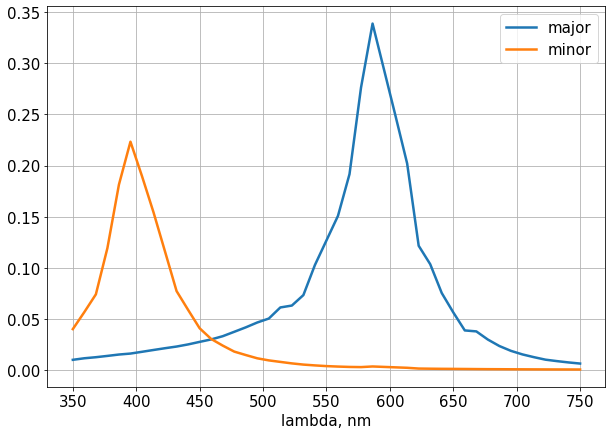

In [45]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
plt.plot((np.linspace(0.35,0.75,45)*1000)[mask], np.array(peak_el[0])[mask], label='major', linewidth=2.5)
plt.plot((np.linspace(0.35,0.75,45)*1000)[mask], np.array(peak_el[1])[mask], label='minor', linewidth=2.5)
plt.legend()
plt.grid()
plt.xlabel('lambda, nm')
#plt.title('ellip '+str(d*2)+'-'+str(d)+'nm')
plt.savefig('cdr/adda_ellip_peaks.png')
plt.show()

In [44]:
mask = np.ones(45, dtype=bool)
mask[27] = False
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

# Cross-sections

## Spheres

In [59]:
from holopy.scattering import calc_cross_sections
Ag_n = np.loadtxt('Ag_wu14.txt')
lamb_min = Ag_n[0,0]; lamb_max = Ag_n[-1,0]
m_ag = {}
m_ag['R'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,1], kind='cubic')
m_ag['I'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,2], kind='cubic')

Sphere 100: 100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 460.59it/s]


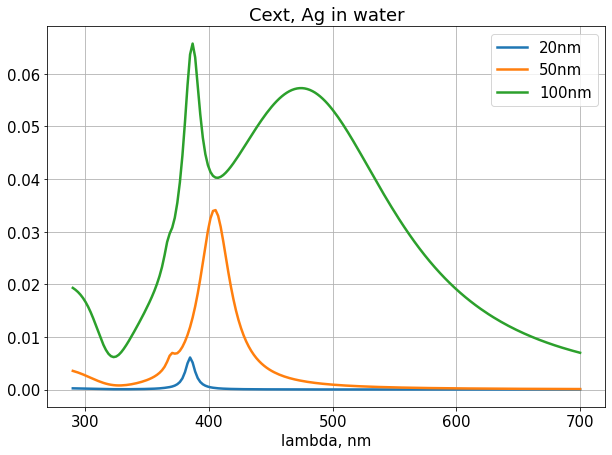

CPU times: user 1.55 s, sys: 55.2 ms, total: 1.61 s
Wall time: 1.6 s


In [61]:
%%time
from holopy.scattering.theory import Mie
cext_sph = {}
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
for d in [20,50,100]:
    #len_dda = Lens(1.38, DDA(max_dpl_size=0.002, use_gpu=True))
    #dda_xsec = DDA(max_dpl_size=0.002, use_gpu=True, suppress_C_output=False)
    mie_xsec = Mie()
    #detector = hp.detector_grid(100, .01)

    cext_sph[str(d)] = []
    for lam in tqdm(np.linspace(0.29,0.7,200), desc='Sphere '+str(d), total=200):
        s_a = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0,0,0))
        xsec = calc_cross_sections(s_a, medium_index=1.33, illum_wavelen=lam, illum_polarization=(1,0), theory=mie_xsec)
        cext_sph[str(d)].append(xsec[2])
        # print(d,'\t',lam,'\t',xsec)
    plt.plot(np.linspace(0.29,0.7,200)*1000, cext_sph[str(d)], label=str(d)+'nm', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.title('Cext, Ag in water')
plt.show()

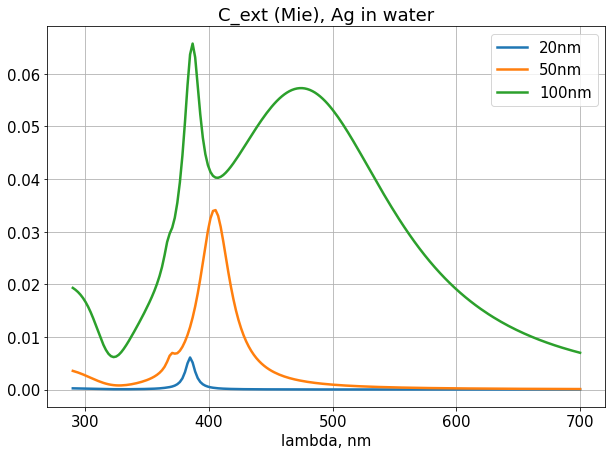

In [100]:
plt.figure(figsize=(10,7))
for d in [20,50,100]:
    plt.plot(np.linspace(0.29,0.7,200)*1000, np.array(cext_sph[str(d)]), label=str(d)+'nm', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.title('C_ext (Mie), Ag in water')
plt.savefig('thesis/cext_sph_mie.png')
plt.show()

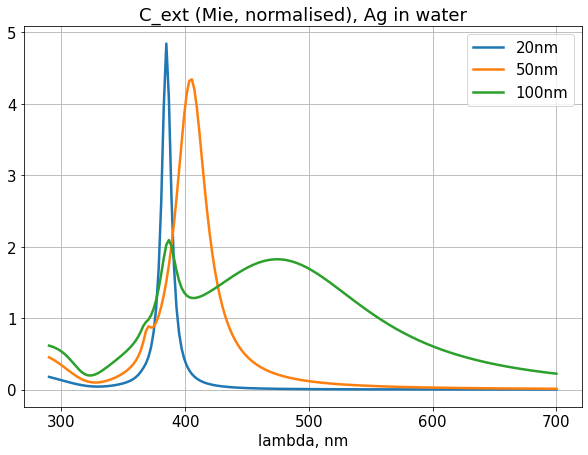

In [101]:
plt.figure(figsize=(10,7))
for d in [20,50,100]:
    plt.plot(np.linspace(0.29,0.7,200)*1000, np.array(cext_sph[str(d)])/(4*np.pi*(d/2*0.001)**2), label=str(d)+'nm', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.title('C_ext (Mie, normalised), Ag in water')
plt.savefig('thesis/cext_sph_mie_norm.png')
plt.show()

### ADDA spheres

In [ ]:
### dda.py redifinition with RAW_CROSS_SECTION

In [89]:
# Copyright 2011-2016, Vinothan N. Manoharan, Thomas G. Dimiduk,
# Rebecca W. Perry, Jerome Fung, Ryan McGorty, Anna Wang, Solomon Barkley
#
# This file is part of HoloPy.
#
# HoloPy is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# HoloPy is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with HoloPy.  If not, see <http://www.gnu.org/licenses/>.
"""
Compute holograms using the discrete dipole approximation (DDA).  Currently uses
ADDA (https://github.com/adda-team/adda) to do DDA calculations.
.. moduleauthor:: Thomas G. Dimiduk <tdimiduk@physics.harvard.edu>
"""

#TODO: Adda currently fails if you call it with things specified in meters
#(values are too small), so we should probably nondimensionalize before talking
#to adda.

import subprocess
import tempfile
import glob
import os
import shutil
import time
import warnings

import numpy as np

from holopy.core.utils import ensure_array, SuppressOutput
from holopy.scattering.scatterer import (
    Ellipsoid, Capsule, Cylinder, Bisphere, Sphere, Scatterer, Spheroid)
from holopy.core.errors import DependencyMissing
from holopy.scattering.theory.scatteringtheory import ScatteringTheory


class DDA(ScatteringTheory):
    """
    Computes scattering using the the Discrete Dipole Approximation (DDA).
    It can (in principle) calculate scattering from any arbitrary scatterer.
    The DDA uses a numerical method that represents arbitrary scatterers as
    an array
    of point dipoles and then self-consistently solves Maxwell's equations
    to determine the scattered field. In practice, this model can be
    extremely computationally intensive, particularly if the size of the
    scatterer is larger than the wavelength of light.  This model requires an
    external scattering code: `a-dda <http://code.google.com/p/a-dda/>`_

    Attributes
    ----------
    n_cpu : int (optional)
        Number of threads to use for the DDA calculation
    max_dpl_size : float (optional)
        Force a maximum dipole size. This is useful for forcing extra
        dipoles if necessary to resolve features in an object. This may
        make dda calculations take much longer.
    use_indicators : bool
        If true, a scatterer's indicators method will be used instead of
        its built-in adda definition
    keep_raw_calculations : bool
        If true, do not delete the temporary file we run ADDA in,
        instead print its path so you can inspect its raw results

    Notes
    -----
    Does not handle near fields. This introduces ~5% error at 10
    microns. This can in principle handle any scatterer, but in practice
    it will need excessive memory or computation time for particularly
    large scatterers.
    """
    def __init__(self, n_cpu=1, use_gpu=False, gpu_id=None, max_dpl_size=None,
                 use_indicators=True, keep_raw_calculations=False, addacmd=[],
                 suppress_C_output=True):

        # Check that adda is present and able to run
        try:
            with SuppressOutput(suppress_output=suppress_C_output):
                subprocess.check_call(['adda', '-V'])
        except (subprocess.CalledProcessError, OSError):
            raise DependencyMissing('adda', "adda is not included with HoloPy "
                "and must be installed separately. You should be able to run "
                "the command 'adda' from a terminal.")

        self.n_cpu = n_cpu
        self.use_gpu = use_gpu
        self.gpu_id = gpu_id
        self.max_dpl_size = max_dpl_size
        self.use_indicators = use_indicators
        self.keep_raw_calculations = keep_raw_calculations
        self.addacmd = addacmd
        self.suppress_C_output = suppress_C_output
        if use_gpu and n_cpu>1: warnings.warn("Adda cannot run on multiple CPUs, when running on GPU. 1 CPU will be used.")
        super().__init__()

    @classmethod
    def can_handle(cls, scatterer):
        # For now DDA is our most general theory, eventually this will have to
        # change if we add other theorys that can compute things ADDA can't (or
        # shouldn't, because it would take crazy long)
        return isinstance(scatterer, Scatterer)

    def _run_adda(self, scatterer, medium_wavevec, medium_index, temp_dir, run_mode):
        medium_wavelen = 2*np.pi/medium_wavevec
        if self.use_gpu:
            cmd = ['adda_ocl']
            if self.gpu_id is not None: cmd.extend(['-gpu',str(self.gpu_id)])
        elif self.n_cpu == 1:
            cmd = ['adda']
        elif self.n_cpu > 1:
            cmd = ['mpiexec', '-n', str(self.n_cpu), 'adda_mpi']
        if run_mode=='scat_matr':
            cmd.extend(['-scat_matr', 'ampl'])
            cmd.extend(['-store_scat_grid'])
        elif run_mode=='cross_sec':
            cmd.extend(['-Csca', '-asym'])
        else:
            msg = "ADDA must run either in scat_matr or cross_sec mode"
            raise NotImplementedError(msg)
        cmd.extend(['-lambda', str(medium_wavelen)])
        cmd.extend(['-save_geom'])
        cmd.extend(self.addacmd)

        predefined = isinstance(scatterer, tuple(_get_predefined_shape.keys()))
        layered=isinstance(scatterer, Sphere) and not np.isscalar(scatterer.r)
        if not predefined or self.use_indicators or layered:
            scat_args = self._adda_discretized(scatterer, medium_wavelen, medium_index, temp_dir)
        else:
            scat_args = self._adda_predefined(scatterer, medium_wavelen, medium_index, temp_dir)
        cmd.extend(scat_args)
        with SuppressOutput(suppress_output=self.suppress_C_output):
            subprocess.check_call(cmd, cwd=temp_dir)

    # TODO: figure out why our discretization gives a different result
    # and fix so that we can use that and eliminate this.
    def _adda_predefined(self, scatterer, medium_wavelen, medium_index, temp_dir):
        scatterer_pars = _get_predefined_shape[scatterer.__class__](scatterer)
        cmd = []
        cmd.extend(['-eq_rad', str(scatterer_pars[0]), '-shape'])
        cmd.extend(scatterer_pars[1])
        cmd.extend(['-m', str(scatterer.n.real/medium_index),
                    str(scatterer.n.imag/medium_index)])
        if hasattr(scatterer, 'rotation'):
            cmd.extend(['-orient'])
            cmd.extend([str(angle*180/np.pi) for angle in reversed(scatterer.rotation)])
            # rotation angles are gamma, beta, alpha in adda reference frame
        return cmd

    def _adda_discretized(self, scatterer, medium_wavelen, medium_index, temp_dir):
        spacing = self.required_spacing(scatterer.bounds, medium_wavelen, medium_index, scatterer.n)
        outf = tempfile.NamedTemporaryFile(dir = temp_dir, delete=False)

        vox = scatterer.voxelate_domains(spacing)
        idx = np.concatenate([g[..., np.newaxis] for g in
                              np.mgrid[[slice(0,d) for d in vox.shape]]],
                             3).reshape((-1, 3))
        vox = vox.flatten()
        ns = ensure_array(scatterer.n)
        n_domains = len(ns)
        if n_domains > 1:
            out = np.hstack((idx, vox[...,np.newaxis]))
            outf.write("Nmat={0}\n".format(n_domains).encode('utf-8'))
        else:
            out = idx
        np.savetxt(outf, out[np.nonzero(vox)], fmt='%d')
        outf.close()

        cmd = []
        cmd.extend(['-shape', 'read', outf.name])
        cmd.extend(
            ['-dpl', str(self._dpl(scatterer.bounds, medium_wavelen, medium_index, scatterer.n))])
        cmd.extend(['-m'])
        for n in ns:
            m = n.real/medium_index
            if m == 1:
                warnings.warn("Adda cannot compute particles with index equal to medium index, adjusting particle index {} to {}".format(m, m+1e-6))
                m += 1e-6
            cmd.extend([str(m), str(n.imag/medium_index)])
        return cmd

    def _dpl(self, bounds, medium_wavelen, medium_index, n):
        # for objects much smaller than wavelength we should use
        # at least 10 dipoles per smallest dimension
        dpl = 10*medium_wavelen / min([np.abs(b[1]-b[0]) for b in bounds])
        # if the object has multiple domains, we need to pick the
        # largest required dipole number
        n = np.abs(n)
        if not np.isscalar(n):
            n = max(n)
        dpl = max(dpl, 10*(n/medium_index))
        # This allows you to fix a largest allowable dipole size (ie
        # so you can resolve features in an object)
        if self.max_dpl_size is not None:
            dpl = max(dpl, medium_wavelen / self.max_dpl_size)
        return dpl

    def required_spacing(self, bounds, medium_wavelen, medium_index, n):
        return medium_wavelen / self._dpl(bounds, medium_wavelen, medium_index, n)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        angles = pos.T[:, 1:] * 180/np.pi
        temp_dir = tempfile.mkdtemp()

        outf = open(os.path.join(temp_dir, 'scat_params.dat'), 'wb')

        # write the header on the scattering angles file
        header = ["global_type=pairs", "N={0}".format(len(angles)), "pairs="]
        outf.write(('\n'.join(header)+'\n').encode('utf-8'))
        # Now write all the angles
        np.savetxt(outf, angles)
        outf.close()

        run_mode = 'scat_matr'
        self._run_adda(
            scatterer, medium_wavevec=medium_wavevec,
            medium_index=medium_index, temp_dir=temp_dir, run_mode=run_mode)

        # Go into the results directory, there should only be one run
        result_dir = glob.glob(os.path.join(temp_dir, 'run000*'))[0]
        if self.keep_raw_calculations:
            self._last_result_dir = result_dir

        adda_result = np.loadtxt(os.path.join(result_dir, 'ampl_scatgrid'),
                                 skiprows=1)
        # columns in result are
        # theta phi s1.r s1.i s2.r s2.i s3.r s3.i s4.r s4.i

        # Combine the real and imaginary components from the file into complex
        # numbers
        s = adda_result[:,2::2] + 1.0j*adda_result[:,3::2]

        # Now arrange them into a scattering matrix, see Bohren and Huffman p63
        # eq 3.12
        scat_matr = np.array([[s[:,1], s[:,2]], [s[:,3], s[:,0]]]).transpose()

        if self.keep_raw_calculations:
            print(("Raw calculations are in: {0}".format(temp_dir)))
        else:
            shutil.rmtree(temp_dir)

        return scat_matr

    def _load_cross_sec(self, path):
        with open(path, 'r') as xsec_file:
            lines = xsec_file.read().split('\n')
            # File contains lines like "Cext    = 0.001"
            xsec_dict = {val.split('=')[0].strip() : val.split('=')[1].strip()
            for val in lines if '=' in val}
        csca = float(xsec_dict['Csca'])
        cabs = float(xsec_dict['Cabs'])
        cext = float(xsec_dict['Cext'])
        asym = eval(xsec_dict['g'])[-1]
        return np.array([csca, cabs, cext, asym])


    def raw_cross_sections(
            self, scatterer, medium_wavevec, medium_index, illum_polarization):
        """
        Calculate scattering, absorption, and extinction cross
        sections, and asymmetry parameter for an arbitrary scatterer.
        --------
        Note: currently only light polarization along X is considered.
        """
        ### TO-DO: implement other light polarizations apart from X.
        ### Possibly, by rotating the scatterer via ADDA parameters

        temp_dir = tempfile.mkdtemp()
        
        outf = open(os.path.join(temp_dir, 'alldir_params.dat'), 'wb')

        # write the default integration angles into the parameter file
        theta_params = ['theta:','min=0','max=180','Jmin=2','Jmax=6',
                        'eps=0','equiv=false','periodic=false']
        outf.write(('\n'.join(theta_params)+'\n').encode('utf-8'))
        phi_params = ['phi:','min=0','max=360','Jmin=2','Jmax=5',
                        'eps=0','equiv=true','periodic=true']
        outf.write(('\n'.join(phi_params)+'\n').encode('utf-8'))
        outf.close()

        run_mode = 'cross_sec'
        self._run_adda(
            scatterer, medium_wavevec=medium_wavevec,
            medium_index=medium_index, temp_dir=temp_dir, run_mode=run_mode)

        # Go into the results directory, there should only be one run
        result_dir = glob.glob(os.path.join(temp_dir, 'run000*'))[0]
        xsec = self._load_cross_sec(os.path.join(result_dir, 'CrossSec-X' if illum_polarization[0] else 'CrossSec-Y'))

        if self.keep_raw_calculations:
            self._last_result_dir = result_dir
            print(("Raw calculations are in: {0}".format(temp_dir)))
        else:
            shutil.rmtree(temp_dir)

        return xsec


_get_predefined_shape = {
        Ellipsoid: lambda s:(s.r[0], ['ellipsoid'] +
                                        [str(r_i/s.r[0]) for r_i in s.r[1:]]),
        Spheroid: lambda s: (s.r[0], ['ellipsoid', '1', str(s.r[1]/s.r[0])]),
        Capsule: lambda s: ((s.h+s.d)/2, ['capsule', str(s.h/s.d)]),
        Cylinder: lambda s: (s.h/2, ['cylinder', str(s.h/s.d)]),
        Bisphere: lambda s: ((s.h+s.d)/2, ['bisphere', str(s.h/s.d)]),
        Sphere: lambda s: (s.r, ['sphere'])}


In [ ]:
%%time
cext_dda = {}
for d in [20,50,100]:
    #len_dda = Lens(1.38, DDA(max_dpl_size=0.002, use_gpu=True))
    dda_xsec = DDA(max_dpl_size=0.002 if d>20 else 0.001, use_gpu=True, suppress_C_output=False)
    #mie_xsec = Mie()
    #detector = hp.detector_grid(100, .01)

    cext_dda[str(d)] = []
    for lam in tqdm(np.linspace(0.29,0.7,50), desc='Sphere '+str(d), total=50):
        s_a = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0,0,0))
        xsec = calc_cross_sections(s_a, medium_index=1.33, illum_wavelen=lam, illum_polarization=(1,0), theory=dda_xsec)
        cext_dda[str(d)].append(xsec[2])
        print(d,'\t',lam,'\t',xsec)

In [ ]:
%%time
## rerun 20nm
for d in [20]:
    #len_dda = Lens(1.38, DDA(max_dpl_size=0.002, use_gpu=True))
    dda_xsec = DDA(max_dpl_size=0.002 if d>20 else 0.001, use_gpu=True, suppress_C_output=False)
    #mie_xsec = Mie()
    #detector = hp.detector_grid(100, .01)

    cext_dda[str(d)] = []
    for lam in tqdm(np.linspace(0.29,0.7,250), desc='Sphere '+str(d), total=250):
        s_a = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0,0,0))
        xsec = calc_cross_sections(s_a, medium_index=1.33, illum_wavelen=lam, illum_polarization=(1,0), theory=dda_xsec)
        cext_dda[str(d)].append(xsec[2])
        print(d,'\t',lam,'\t',xsec)

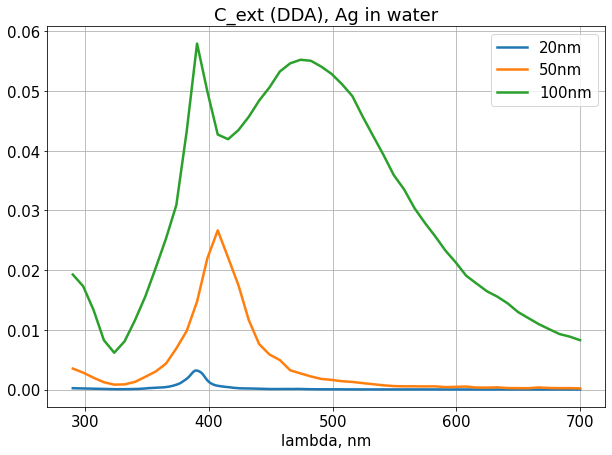

In [102]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
for d in [20,50,100]:
    if d>20:
        plt.plot(np.linspace(0.29,0.7,50)*1000, np.array(cext_dda[str(d)]), label=str(d)+'nm', linewidth=2.5)
    else:
        plt.plot(np.linspace(0.29,0.7,250)*1000, np.array(cext_dda[str(d)]), label=str(d)+'nm', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.title('C_ext (DDA), Ag in water')
plt.savefig('thesis/cext_sph_dda.png')
plt.show()

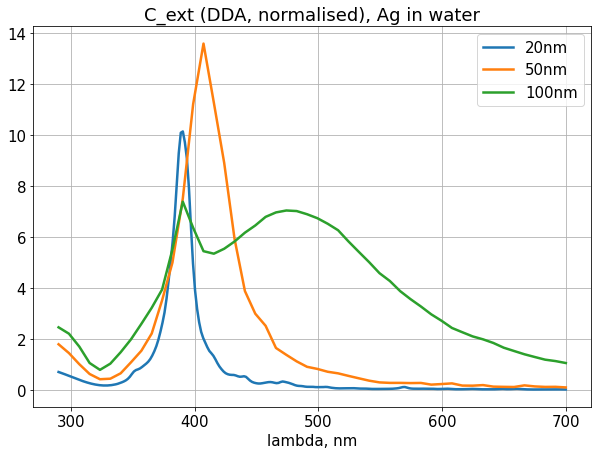

In [103]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
for d in [20,50,100]:
    if d>20:
        plt.plot(np.linspace(0.29,0.7,50)*1000, np.array(cext_dda[str(d)])/(np.pi*(d/2*0.001)**2), label=str(d)+'nm', linewidth=2.5)
    else:
        plt.plot(np.linspace(0.29,0.7,250)*1000, np.array(cext_dda[str(d)])/(np.pi*(d/2*0.001)**2), label=str(d)+'nm', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.title('C_ext (DDA, normalised), Ag in water')
plt.savefig('thesis/cext_sph_dda_norm.png')
plt.show()

## Ellipsoid XY-pol

In [ ]:
%%time
d = 50
cext_ellip = {}
for p in ['X','Y']:
    #len_dda = Lens(1.38, DDA(max_dpl_size=0.002, use_gpu=True))
    dda_xsec = DDA(max_dpl_size=0.002, use_gpu=True, suppress_C_output=False)
    #mie_xsec = Mie()
    #detector = hp.detector_grid(100, .01)

    cext_ellip[p] = []
    for lam in tqdm(np.linspace(0.29,0.7,50), desc='Polar '+p, total=50):
        # s_a = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0,0,0))
        s_a = Ellipsoid(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = (d*1e-3,d/2*1e-3,d/2*1e-3), center = (0,0,0))
        xsec = calc_cross_sections(s_a, medium_index=1.33, illum_wavelen=lam, illum_polarization=(1,0) if p=='X' else (0,1), theory=dda_xsec)
        cext_ellip[p].append(xsec[2])
        print(p,'\t',lam,'\t',xsec)

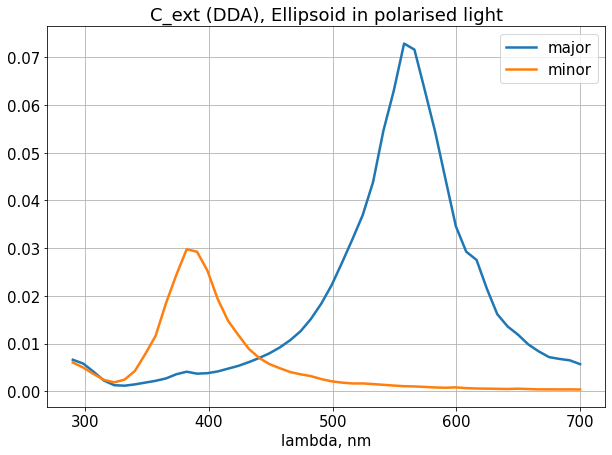

In [96]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
for p in ['X','Y']:
    plt.plot(np.linspace(0.29,0.7,50)*1000, np.array(cext_ellip[p]), label='major' if p=='X' else 'minor', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.title('C_ext (DDA), Ellipsoid in polarised light')
plt.show()

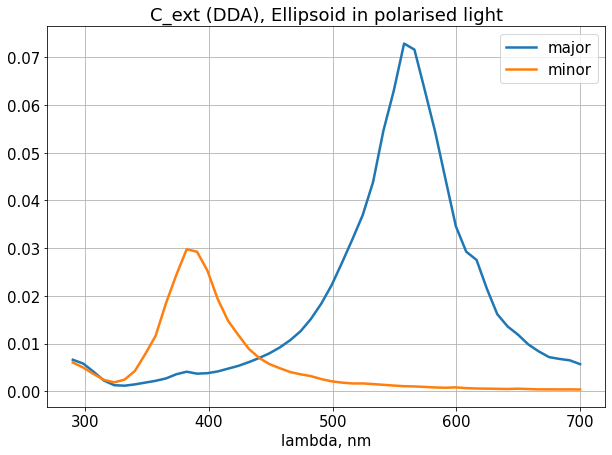

In [97]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
for p in ['X','Y']:
    plt.plot(np.linspace(0.29,0.7,50)*1000, np.array(cext_ellip[p]), label='major' if p=='X' else 'minor', linewidth=2.5)
plt.legend()
plt.xlabel('lambda, nm')
plt.grid()
plt.title('C_ext (DDA), Ellipsoid in polarised light')
plt.savefig('thesis/cext_ellip.png')
plt.show()

# Emulsion refraction plot

In [4]:
def right_max(xsec, lam):
    for i in range(len(xsec)):
        if xsec[-i-1]>xsec[-i-2] and xsec[-i-2]>xsec[-i-3]:
            i_peak = -i-1
            break
    return lam[i_peak]

### Spheres

In [5]:
from holopy.scattering import calc_cross_sections
Ag_n = np.loadtxt('Ag_wu14.txt')
lamb_min = Ag_n[0,0]; lamb_max = Ag_n[-1,0]
m_ag = {}
m_ag['R'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,1], kind='cubic')
m_ag['I'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,2], kind='cubic')

In [6]:
%%time
from holopy.scattering.theory import Mie
peak_sph = {}
# plt.rcParams.update({'font.size': 15})
# plt.figure(figsize=(10,7))
# for n_ref in [1.25,1.33,1.515,1.6,1.7]:
#     peak_sph[n] = {}
#     for d in [20,40,60,80,100]:
#         mie_xsec = Mie()
        

for d in [20,40,60,80,100]:
    peak_sph[d] = []
    for n_ref in tqdm([1.25,1.33,1.515,1.6,1.7], desc='n_ref iter, Sphere '+str(d)):
        mie_xsec = Mie()
        cext_sph = []
        for lam in np.linspace(0.29,0.7,200):#tqdm(np.linspace(0.29,0.7,200), desc='Sphere '+str(d), total=200):
            s_a = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0,0,0))
            xsec = calc_cross_sections(s_a, medium_index=n_ref, illum_wavelen=lam, illum_polarization=(1,0), theory=mie_xsec)
            cext_sph.append(xsec[2])
        peak_sph[d].append(right_max(cext_sph, np.linspace(0.29,0.7,200)*1000))
    print(d, np.around(peak_sph[d], decimals=1))
print('\n')
        # print(d,'\t',lam,'\t',xsec)
#     plt.plot(np.linspace(0.29,0.7,200)*1000, cext_sph[str(d)], label=str(d)+'nm', linewidth=2.5)
# plt.legend()
# plt.xlabel('lambda, nm')
# plt.grid()
# plt.title('Cext, Ag in water')
# plt.show()

n_ref iter, Sphere 20: 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


20 [376.5 384.8 405.4 417.7 430.1]


n_ref iter, Sphere 40: 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


40 [386.8 397.1 423.9 436.3 452.8]


n_ref iter, Sphere 60: 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


60 [401.3 415.7 448.6 467.2 487.8]


n_ref iter, Sphere 80: 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


80 [423.9 440.4 483.7 506.3 531.1]


n_ref iter, Sphere 100: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]

100 [452.8 475.4 529.  553.7 584.6]


CPU times: user 11.1 s, sys: 399 ms, total: 11.5 s
Wall time: 11.4 s


In [7]:
for d in [20,40,60,80,100]:
    print(d, np.around(peak_sph[d], decimals=1))
print('\n')

20 [376.5 384.8 405.4 417.7 430.1]
40 [386.8 397.1 423.9 436.3 452.8]
60 [401.3 415.7 448.6 467.2 487.8]
80 [423.9 440.4 483.7 506.3 531.1]
100 [452.8 475.4 529.  553.7 584.6]




In [8]:
%%time
from holopy.scattering.theory import Mie
peak_sph = {}
# plt.rcParams.update({'font.size': 15})
# plt.figure(figsize=(10,7))
# for n_ref in [1.25,1.33,1.515,1.6,1.7]:
#     peak_sph[n] = {}
#     for d in [20,40,60,80,100]:
#         mie_xsec = Mie()
        

for d in [20,40,60,80,100]:
    peak_sph[d] = []
    for n_ref in tqdm([1.25,1.33,1.515,1.6,1.7], desc='n_ref iter, Sphere '+str(d)):
        mie_xsec = Mie()
        cext_sph = []
        for lam in np.linspace(0.29,0.7,200):#tqdm(np.linspace(0.29,0.7,200), desc='Sphere '+str(d), total=200):
            s_a = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0,0,0))
            xsec = calc_cross_sections(s_a, medium_index=n_ref, illum_wavelen=lam, illum_polarization=(1,0), theory=mie_xsec)
            cext_sph.append(xsec[0])
        peak_sph[d].append(right_max(cext_sph, np.linspace(0.29,0.7,200)*1000))
    print(d, np.around(peak_sph[d], decimals=1))
print('\n')
        # print(d,'\t',lam,'\t',xsec)
#     plt.plot(np.linspace(0.29,0.7,200)*1000, cext_sph[str(d)], label=str(d)+'nm', linewidth=2.5)
# plt.legend()
# plt.xlabel('lambda, nm')
# plt.grid()
# plt.title('Cext, Ag in water')
# plt.show()

n_ref iter, Sphere 20: 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


20 [376.5 384.8 405.4 417.7 430.1]


n_ref iter, Sphere 40: 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


40 [386.8 397.1 423.9 436.3 452.8]


n_ref iter, Sphere 60: 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


60 [401.3 415.7 448.6 467.2 487.8]


n_ref iter, Sphere 80: 100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


80 [423.9 440.4 483.7 506.3 531.1]


n_ref iter, Sphere 100: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]

100 [452.8 475.4 529.  553.7 584.6]


CPU times: user 11.1 s, sys: 465 ms, total: 11.5 s
Wall time: 11.5 s


In [9]:
for d in [20,40,60,80,100]:
    print(d, np.around(peak_sph[d], decimals=1))
print('\n')

20 [376.5 384.8 405.4 417.7 430.1]
40 [386.8 397.1 423.9 436.3 452.8]
60 [401.3 415.7 448.6 467.2 487.8]
80 [423.9 440.4 483.7 506.3 531.1]
100 [452.8 475.4 529.  553.7 584.6]




### Ellipsoid

In [ ]:
### dda.py redifinition with RAW_CROSS_SECTION

In [4]:
# Copyright 2011-2016, Vinothan N. Manoharan, Thomas G. Dimiduk,
# Rebecca W. Perry, Jerome Fung, Ryan McGorty, Anna Wang, Solomon Barkley
#
# This file is part of HoloPy.
#
# HoloPy is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# HoloPy is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with HoloPy.  If not, see <http://www.gnu.org/licenses/>.
"""
Compute holograms using the discrete dipole approximation (DDA).  Currently uses
ADDA (https://github.com/adda-team/adda) to do DDA calculations.
.. moduleauthor:: Thomas G. Dimiduk <tdimiduk@physics.harvard.edu>
"""

#TODO: Adda currently fails if you call it with things specified in meters
#(values are too small), so we should probably nondimensionalize before talking
#to adda.

import subprocess
import tempfile
import glob
import os
import shutil
import time
import warnings

import numpy as np

from holopy.core.utils import ensure_array, SuppressOutput
from holopy.scattering.scatterer import (
    Ellipsoid, Capsule, Cylinder, Bisphere, Sphere, Scatterer, Spheroid)
from holopy.core.errors import DependencyMissing
from holopy.scattering.theory.scatteringtheory import ScatteringTheory


class DDA(ScatteringTheory):
    """
    Computes scattering using the the Discrete Dipole Approximation (DDA).
    It can (in principle) calculate scattering from any arbitrary scatterer.
    The DDA uses a numerical method that represents arbitrary scatterers as
    an array
    of point dipoles and then self-consistently solves Maxwell's equations
    to determine the scattered field. In practice, this model can be
    extremely computationally intensive, particularly if the size of the
    scatterer is larger than the wavelength of light.  This model requires an
    external scattering code: `a-dda <http://code.google.com/p/a-dda/>`_

    Attributes
    ----------
    n_cpu : int (optional)
        Number of threads to use for the DDA calculation
    max_dpl_size : float (optional)
        Force a maximum dipole size. This is useful for forcing extra
        dipoles if necessary to resolve features in an object. This may
        make dda calculations take much longer.
    use_indicators : bool
        If true, a scatterer's indicators method will be used instead of
        its built-in adda definition
    keep_raw_calculations : bool
        If true, do not delete the temporary file we run ADDA in,
        instead print its path so you can inspect its raw results

    Notes
    -----
    Does not handle near fields. This introduces ~5% error at 10
    microns. This can in principle handle any scatterer, but in practice
    it will need excessive memory or computation time for particularly
    large scatterers.
    """
    def __init__(self, n_cpu=1, use_gpu=False, gpu_id=None, max_dpl_size=None,
                 use_indicators=True, keep_raw_calculations=False, addacmd=[],
                 suppress_C_output=True):

        # Check that adda is present and able to run
        try:
            with SuppressOutput(suppress_output=suppress_C_output):
                subprocess.check_call(['adda', '-V'])
        except (subprocess.CalledProcessError, OSError):
            raise DependencyMissing('adda', "adda is not included with HoloPy "
                "and must be installed separately. You should be able to run "
                "the command 'adda' from a terminal.")

        self.n_cpu = n_cpu
        self.use_gpu = use_gpu
        self.gpu_id = gpu_id
        self.max_dpl_size = max_dpl_size
        self.use_indicators = use_indicators
        self.keep_raw_calculations = keep_raw_calculations
        self.addacmd = addacmd
        self.suppress_C_output = suppress_C_output
        if use_gpu and n_cpu>1: warnings.warn("Adda cannot run on multiple CPUs, when running on GPU. 1 CPU will be used.")
        super().__init__()

    @classmethod
    def can_handle(cls, scatterer):
        # For now DDA is our most general theory, eventually this will have to
        # change if we add other theorys that can compute things ADDA can't (or
        # shouldn't, because it would take crazy long)
        return isinstance(scatterer, Scatterer)

    def _run_adda(self, scatterer, medium_wavevec, medium_index, temp_dir, run_mode):
        medium_wavelen = 2*np.pi/medium_wavevec
        if self.use_gpu:
            cmd = ['adda_ocl']
            if self.gpu_id is not None: cmd.extend(['-gpu',str(self.gpu_id)])
        elif self.n_cpu == 1:
            cmd = ['adda']
        elif self.n_cpu > 1:
            cmd = ['mpiexec', '-n', str(self.n_cpu), 'adda_mpi']
        if run_mode=='scat_matr':
            cmd.extend(['-scat_matr', 'ampl'])
            cmd.extend(['-store_scat_grid'])
        elif run_mode=='cross_sec':
            cmd.extend(['-Csca', '-asym'])
        else:
            msg = "ADDA must run either in scat_matr or cross_sec mode"
            raise NotImplementedError(msg)
        cmd.extend(['-lambda', str(medium_wavelen)])
        cmd.extend(['-save_geom'])
        cmd.extend(self.addacmd)

        predefined = isinstance(scatterer, tuple(_get_predefined_shape.keys()))
        layered=isinstance(scatterer, Sphere) and not np.isscalar(scatterer.r)
        if not predefined or self.use_indicators or layered:
            scat_args = self._adda_discretized(scatterer, medium_wavelen, medium_index, temp_dir)
        else:
            scat_args = self._adda_predefined(scatterer, medium_wavelen, medium_index, temp_dir)
        cmd.extend(scat_args)
        with SuppressOutput(suppress_output=self.suppress_C_output):
            subprocess.check_call(cmd, cwd=temp_dir)

    # TODO: figure out why our discretization gives a different result
    # and fix so that we can use that and eliminate this.
    def _adda_predefined(self, scatterer, medium_wavelen, medium_index, temp_dir):
        scatterer_pars = _get_predefined_shape[scatterer.__class__](scatterer)
        cmd = []
        cmd.extend(['-eq_rad', str(scatterer_pars[0]), '-shape'])
        cmd.extend(scatterer_pars[1])
        cmd.extend(['-m', str(scatterer.n.real/medium_index),
                    str(scatterer.n.imag/medium_index)])
        if hasattr(scatterer, 'rotation'):
            cmd.extend(['-orient'])
            cmd.extend([str(angle*180/np.pi) for angle in reversed(scatterer.rotation)])
            # rotation angles are gamma, beta, alpha in adda reference frame
        return cmd

    def _adda_discretized(self, scatterer, medium_wavelen, medium_index, temp_dir):
        spacing = self.required_spacing(scatterer.bounds, medium_wavelen, medium_index, scatterer.n)
        outf = tempfile.NamedTemporaryFile(dir = temp_dir, delete=False)

        vox = scatterer.voxelate_domains(spacing)
        idx = np.concatenate([g[..., np.newaxis] for g in
                              np.mgrid[[slice(0,d) for d in vox.shape]]],
                             3).reshape((-1, 3))
        vox = vox.flatten()
        ns = ensure_array(scatterer.n)
        n_domains = len(ns)
        if n_domains > 1:
            out = np.hstack((idx, vox[...,np.newaxis]))
            outf.write("Nmat={0}\n".format(n_domains).encode('utf-8'))
        else:
            out = idx
        np.savetxt(outf, out[np.nonzero(vox)], fmt='%d')
        outf.close()

        cmd = []
        cmd.extend(['-shape', 'read', outf.name])
        cmd.extend(
            ['-dpl', str(self._dpl(scatterer.bounds, medium_wavelen, medium_index, scatterer.n))])
        cmd.extend(['-m'])
        for n in ns:
            m = n.real/medium_index
            if m == 1:
                warnings.warn("Adda cannot compute particles with index equal to medium index, adjusting particle index {} to {}".format(m, m+1e-6))
                m += 1e-6
            cmd.extend([str(m), str(n.imag/medium_index)])
        return cmd

    def _dpl(self, bounds, medium_wavelen, medium_index, n):
        # for objects much smaller than wavelength we should use
        # at least 10 dipoles per smallest dimension
        dpl = 10*medium_wavelen / min([np.abs(b[1]-b[0]) for b in bounds])
        # if the object has multiple domains, we need to pick the
        # largest required dipole number
        n = np.abs(n)
        if not np.isscalar(n):
            n = max(n)
        dpl = max(dpl, 10*(n/medium_index))
        # This allows you to fix a largest allowable dipole size (ie
        # so you can resolve features in an object)
        if self.max_dpl_size is not None:
            dpl = max(dpl, medium_wavelen / self.max_dpl_size)
        return dpl

    def required_spacing(self, bounds, medium_wavelen, medium_index, n):
        return medium_wavelen / self._dpl(bounds, medium_wavelen, medium_index, n)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        angles = pos.T[:, 1:] * 180/np.pi
        temp_dir = tempfile.mkdtemp()

        outf = open(os.path.join(temp_dir, 'scat_params.dat'), 'wb')

        # write the header on the scattering angles file
        header = ["global_type=pairs", "N={0}".format(len(angles)), "pairs="]
        outf.write(('\n'.join(header)+'\n').encode('utf-8'))
        # Now write all the angles
        np.savetxt(outf, angles)
        outf.close()

        run_mode = 'scat_matr'
        self._run_adda(
            scatterer, medium_wavevec=medium_wavevec,
            medium_index=medium_index, temp_dir=temp_dir, run_mode=run_mode)

        # Go into the results directory, there should only be one run
        result_dir = glob.glob(os.path.join(temp_dir, 'run000*'))[0]
        if self.keep_raw_calculations:
            self._last_result_dir = result_dir

        adda_result = np.loadtxt(os.path.join(result_dir, 'ampl_scatgrid'),
                                 skiprows=1)
        # columns in result are
        # theta phi s1.r s1.i s2.r s2.i s3.r s3.i s4.r s4.i

        # Combine the real and imaginary components from the file into complex
        # numbers
        s = adda_result[:,2::2] + 1.0j*adda_result[:,3::2]

        # Now arrange them into a scattering matrix, see Bohren and Huffman p63
        # eq 3.12
        scat_matr = np.array([[s[:,1], s[:,2]], [s[:,3], s[:,0]]]).transpose()

        if self.keep_raw_calculations:
            print(("Raw calculations are in: {0}".format(temp_dir)))
        else:
            shutil.rmtree(temp_dir)

        return scat_matr

    def _load_cross_sec(self, path):
        with open(path, 'r') as xsec_file:
            lines = xsec_file.read().split('\n')
            # File contains lines like "Cext    = 0.001"
            xsec_dict = {val.split('=')[0].strip() : val.split('=')[1].strip()
            for val in lines if '=' in val}
        csca = float(xsec_dict['Csca'])
        cabs = float(xsec_dict['Cabs'])
        cext = float(xsec_dict['Cext'])
        asym = eval(xsec_dict['g'])[-1]
        return np.array([csca, cabs, cext, asym])


    def raw_cross_sections(
            self, scatterer, medium_wavevec, medium_index, illum_polarization):
        """
        Calculate scattering, absorption, and extinction cross
        sections, and asymmetry parameter for an arbitrary scatterer.
        --------
        Note: currently only light polarization along X is considered.
        """
        ### TO-DO: implement other light polarizations apart from X.
        ### Possibly, by rotating the scatterer via ADDA parameters

        temp_dir = tempfile.mkdtemp()
        
        outf = open(os.path.join(temp_dir, 'alldir_params.dat'), 'wb')

        # write the default integration angles into the parameter file
        theta_params = ['theta:','min=0','max=180','Jmin=2','Jmax=6',
                        'eps=0','equiv=false','periodic=false']
        outf.write(('\n'.join(theta_params)+'\n').encode('utf-8'))
        phi_params = ['phi:','min=0','max=360','Jmin=2','Jmax=5',
                        'eps=0','equiv=true','periodic=true']
        outf.write(('\n'.join(phi_params)+'\n').encode('utf-8'))
        outf.close()

        run_mode = 'cross_sec'
        self._run_adda(
            scatterer, medium_wavevec=medium_wavevec,
            medium_index=medium_index, temp_dir=temp_dir, run_mode=run_mode)

        # Go into the results directory, there should only be one run
        result_dir = glob.glob(os.path.join(temp_dir, 'run000*'))[0]
        xsec = self._load_cross_sec(os.path.join(result_dir, 'CrossSec-X' if illum_polarization[0] else 'CrossSec-Y'))

        if self.keep_raw_calculations:
            self._last_result_dir = result_dir
            print(("Raw calculations are in: {0}".format(temp_dir)))
        else:
            shutil.rmtree(temp_dir)

        return xsec


_get_predefined_shape = {
        Ellipsoid: lambda s:(s.r[0], ['ellipsoid'] +
                                        [str(r_i/s.r[0]) for r_i in s.r[1:]]),
        Spheroid: lambda s: (s.r[0], ['ellipsoid', '1', str(s.r[1]/s.r[0])]),
        Capsule: lambda s: ((s.h+s.d)/2, ['capsule', str(s.h/s.d)]),
        Cylinder: lambda s: (s.h/2, ['cylinder', str(s.h/s.d)]),
        Bisphere: lambda s: ((s.h+s.d)/2, ['bisphere', str(s.h/s.d)]),
        Sphere: lambda s: (s.r, ['sphere'])}


In [5]:
from holopy.scattering import calc_cross_sections
Ag_n = np.loadtxt('Ag_wu14.txt')
lamb_min = Ag_n[0,0]; lamb_max = Ag_n[-1,0]
m_ag = {}
m_ag['R'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,1], kind='cubic')
m_ag['I'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,2], kind='cubic')

In [6]:
sizes = [(80,45), (100,50), (120,45)]
for x,y in sizes:
    print(x,y)

80 45
100 50
120 45


In [ ]:
%%time
sizes = [(80,45), (100,50), (120,45)]
peak_ell = {}

for dx,dy in sizes:
    peak_ell[str(dx)+'_'+str(dy)] = []
    for n_ref in tqdm([1.25,1.33,1.515,1.6,1.7], desc='n_ref iter, ellip '+str(dx)+'_'+str(dy)):
        dda_xsec = DDA(max_dpl_size=0.002, use_gpu=True, suppress_C_output=False)
        cext_ell = []
        for lam in np.linspace(0.29,0.7,50):#tqdm(np.linspace(0.29,0.7,200), desc='Sphere '+str(d), total=200):
            s_a = Ellipsoid(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = (dx/2*1e-3,dy/2*1e-3,dy/2*1e-3), center = (0,0,0))
            xsec = calc_cross_sections(s_a, medium_index=n_ref, illum_wavelen=lam, illum_polarization=(1,0), theory=dda_xsec)
            cext_ell.append(xsec[2])
        peak_ell[str(dx)+'_'+str(dy)].append(right_max(cext_ell, np.linspace(0.29,0.7,50)*1000))
    print(str(dx)+'_'+str(dy),'\t', np.around(peak_ell[str(dx)+'_'+str(dy)], decimals=1))
print('\n')

In [ ]:
for dx,dy in sizes:
    print(str(dx)+'_'+str(dy),'\t', np.around(peak_ell[str(dx)+'_'+str(dy)], decimals=1))
print('\n')

In [ ]:
peak_ell

In [ ]:
%%time
d = 50
cext_ellip = {}
for p in ['X','Y']:
    #len_dda = Lens(1.38, DDA(max_dpl_size=0.002, use_gpu=True))
    dda_xsec = DDA(max_dpl_size=0.002, use_gpu=True, suppress_C_output=False)
    #mie_xsec = Mie()
    #detector = hp.detector_grid(100, .01)

    cext_ellip[p] = []
    for lam in tqdm(np.linspace(0.29,0.7,50), desc='Polar '+p, total=50):
        # s_a = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0,0,0))
        s_a = Ellipsoid(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = (d*1e-3,d/2*1e-3,d/2*1e-3), center = (0,0,0))
        xsec = calc_cross_sections(s_a, medium_index=1.33, illum_wavelen=lam, illum_polarization=(1,0) if p=='X' else (0,1), theory=dda_xsec)
        cext_ellip[p].append(xsec[2])
        print(p,'\t',lam,'\t',xsec)

# Unpolarised light

In [92]:
Ag_n = np.loadtxt('Ag_wu14.txt')
lamb_min = Ag_n[0,0]; lamb_max = Ag_n[-1,0]
m_ag = {}
m_ag['R'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,1], kind='cubic')
m_ag['I'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,2], kind='cubic')
#mask = (ag_n[:,0]>0.35) & (ag_n[:,0]<0.65)
#ag_mask = ag_n[mask]

## Ellipsoid

In [93]:
m_ag['R'](0.460)+1j*m_ag['I'](0.460)

(0.035088672979351476+2.808694501227488j)

In [ ]:
%%time
ell = Ellipsoid(r = (0.1,0.05,0.05), n = m_ag['R'](0.460)+1j*m_ag['I'](0.460), center = (0.5,0.5,0))
detector = hp.detector_grid(100, .01)

len_dda = Lens(1.38, DDA(use_gpu=True, suppress_C_output=False))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

/home/scanner-ml/anaconda3/envs/ML_rebuild/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


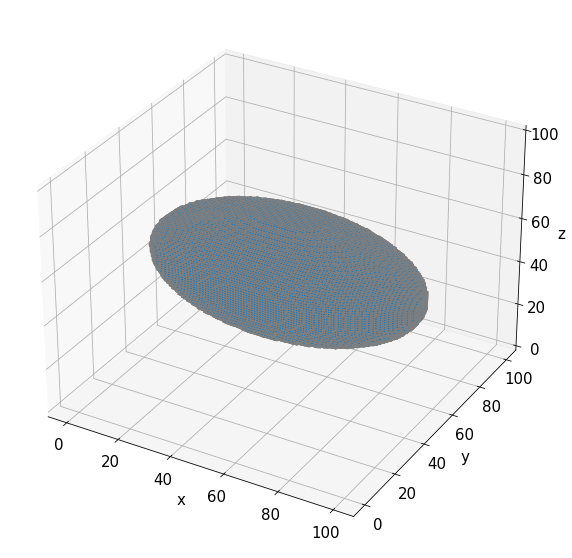

CPU times: user 59.6 s, sys: 653 ms, total: 1min
Wall time: 59.3 s


In [95]:
%%time
#from holopy.scattering.scatterer import Indicators
#indi = Indicators(lambda x: sph_rule(x, R=0.5, delta=1))
#copa_sph = Scatterer(indi, n=1.5, center=(1,1,0))

from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

filam = np.array(ell.voxelate(spacing=0.002), dtype=bool)

#filled = np.zeros((filam[:,0].max()+1, filam[:,1].max()+1, filam[:,2].max()+1), dtype=bool)
#for c in filam:
#    filled[c[0],c[1],c[2]] = True

copa_fil = np.concatenate((np.zeros((100,24,50), dtype=bool), filam, np.zeros((100,25,50), dtype=bool)), axis=1)
copa_fil_fil = np.concatenate((np.zeros((100,100,25), dtype=bool), copa_fil, np.zeros((100,100,25), dtype=bool)), axis=2)
ax = make_ax(True)
ax.voxels(copa_fil_fil, edgecolors='gray', shade=False)
plt.savefig('thesis/ellip_voxel.png')
plt.show()

In [52]:
copa_fil_fil.shape

(100, 100, 100)

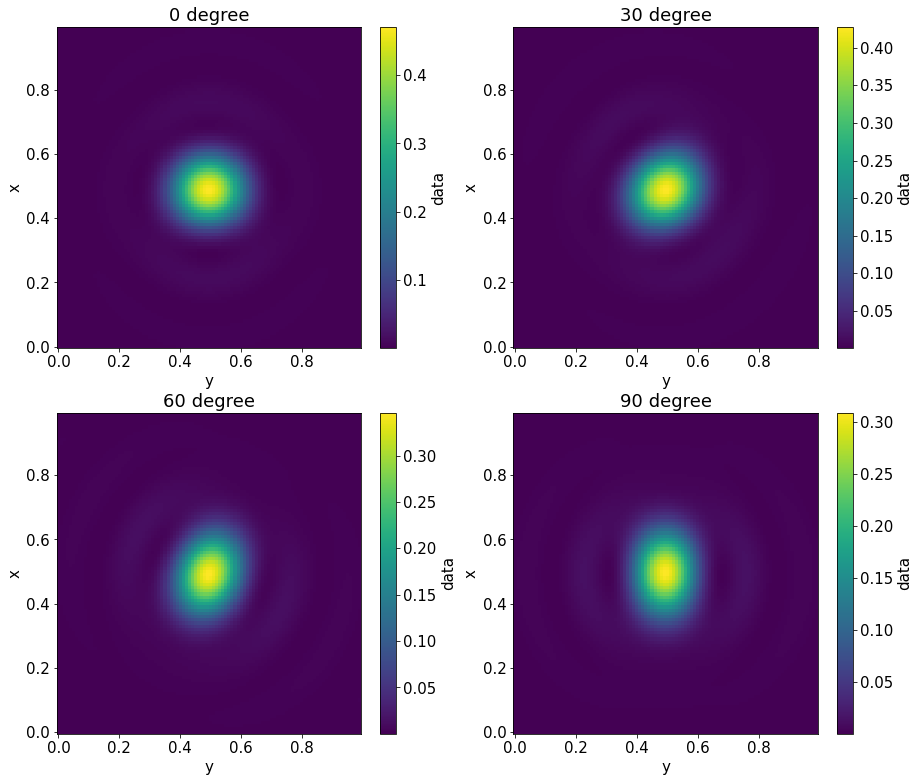

In [53]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
plt.show()

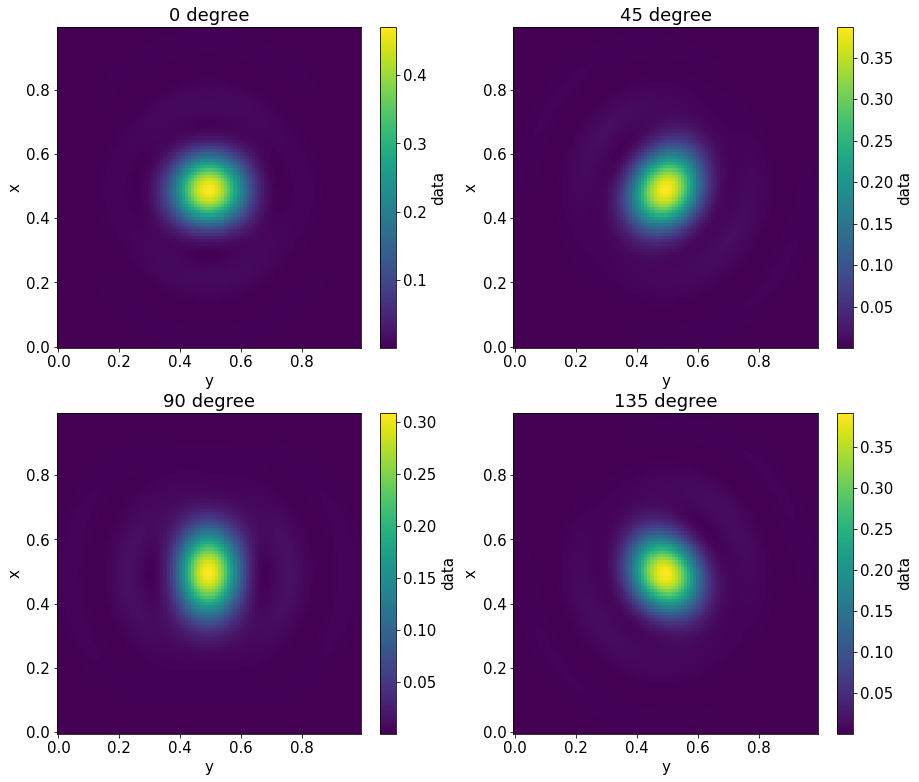

In [54]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,45,90,135]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
plt.savefig('thesis/ellip_pol.png')
plt.show()

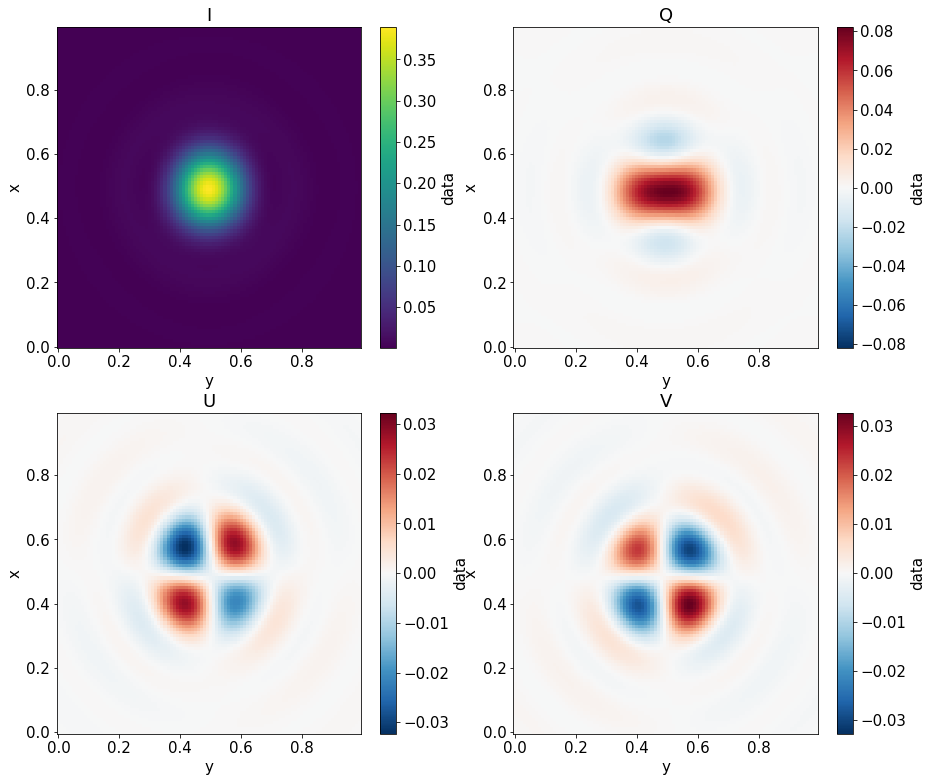

In [55]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
holo_unp.sel(S='I').plot(ax=axes[0])
axes[0].set_title('I')
holo_unp.sel(S='Q').plot(ax=axes[1])
axes[1].set_title('Q')
holo_unp.sel(S='U').plot(ax=axes[2])
axes[2].set_title('U')
holo_unp.sel(S='V').plot(ax=axes[3])
axes[3].set_title('V')
plt.savefig('thesis/ellip_unpol.png')
plt.show()

In [ ]:
ell = Ellipsoid(r = (0.05,0.1,0.05), n = 0.035+1j*2.809, center = (0.5,0.5,0))
detector = hp.detector_grid(100, .01)

len_dda = Lens(1.38, DDA(use_gpu=True, suppress_C_output=False))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

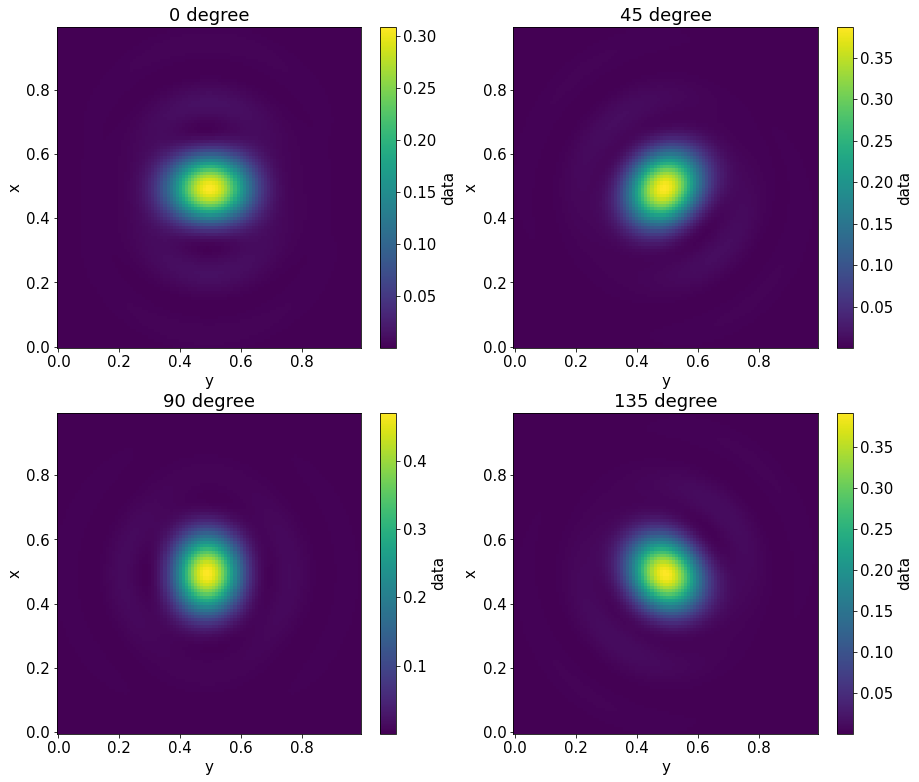

In [8]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,45,90,135]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
plt.show()

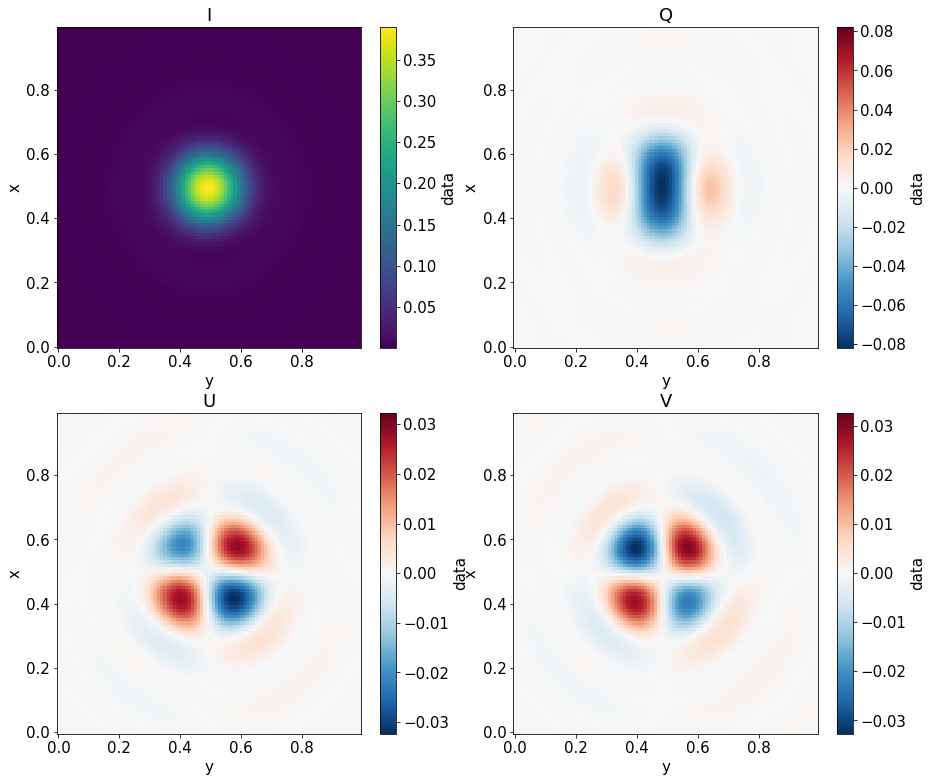

In [9]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
holo_unp.sel(S='I').plot(ax=axes[0])
axes[0].set_title('I')
holo_unp.sel(S='Q').plot(ax=axes[1])
axes[1].set_title('Q')
holo_unp.sel(S='U').plot(ax=axes[2])
axes[2].set_title('U')
holo_unp.sel(S='V').plot(ax=axes[3])
axes[3].set_title('V')
# plt.savefig('cdr/adda_biellip_unpol.png')
plt.show()

## Bielipsoid

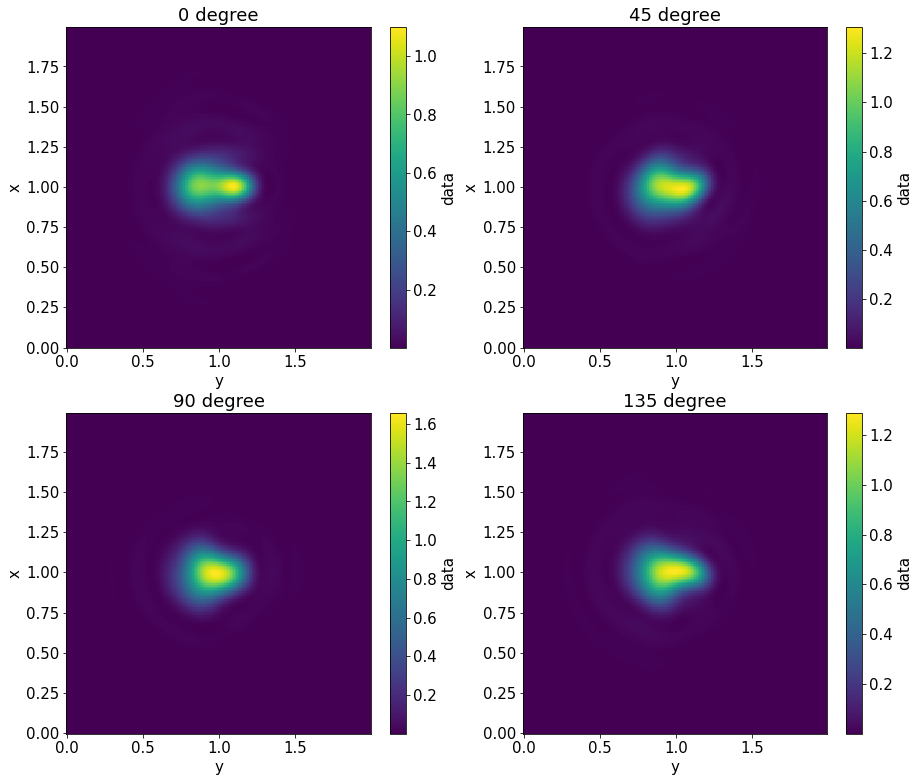

In [48]:
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, DDA(use_gpu=True))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = calc_unpolar(detector, scat=biel, medium_index=1.515, illum_wavelen=0.4, theory=len_dda)

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,45,90,135]):
    th *= np.pi/180
    holo_th = apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
plt.savefig('cdr/adda_biellip_pol.png')
plt.show()

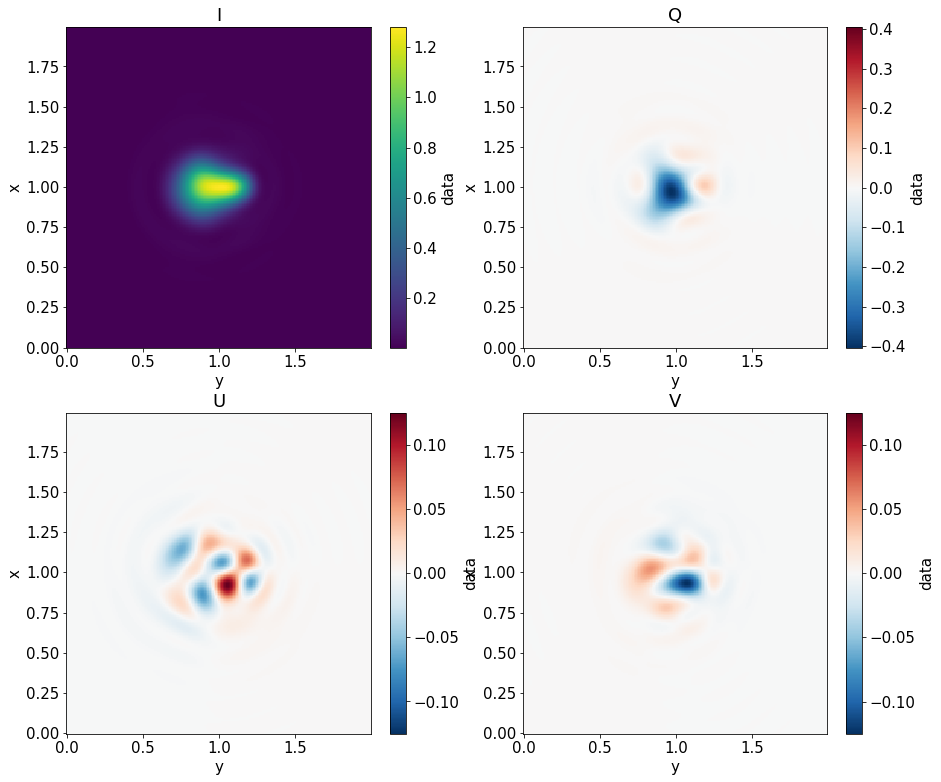

In [49]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
holo_unp.sel(S='I').plot(ax=axes[0])
axes[0].set_title('I')
holo_unp.sel(S='Q').plot(ax=axes[1])
axes[1].set_title('Q')
holo_unp.sel(S='U').plot(ax=axes[2])
axes[2].set_title('U')
holo_unp.sel(S='V').plot(ax=axes[3])
axes[3].set_title('V')
plt.savefig('cdr/adda_biellip_unpol.png')
plt.show()

# Colour light

In [3]:
led_stats = pd.read_csv('LED_CBT-140.csv')
led_stats.dropna(axis=1).head(5)
#led_stats.head(5)

,lambda,LED,Blue,Green,Red,Diffuser,Polarizer,BS,Mirror,Lens-4,Lens-3,Lens-2,Lens-1,UV/IR,Blue.1,Green.1,Red.1
0,400,0.033582,0.177239,0.029851,0.048507,0.790258,1,0.523824,0.997866,0.93,0.91,0.97,0.96,0.93,0.001798,0.000303,0.000492
1,410,0.022388,0.257463,0.035448,0.035448,0.795796,1,0.504734,0.999045,0.95,0.94,0.98,0.97,0.93,0.001810,0.000249,0.000249
2,420,0.070896,0.281716,0.041045,0.029851,0.801042,1,0.491003,0.998302,0.96,0.95,0.98,0.98,0.91,0.006334,0.000923,0.000671
3,430,0.186567,0.317164,0.039179,0.024254,0.806006,1,0.488546,0.999146,0.97,0.96,0.99,0.99,0.93,0.019557,0.002416,0.001496
4,440,0.447761,0.347015,0.048507,0.014925,0.810698,1,0.489405,0.998541,0.97,0.96,0.99,0.99,0.91,0.051266,0.007166,0.002205


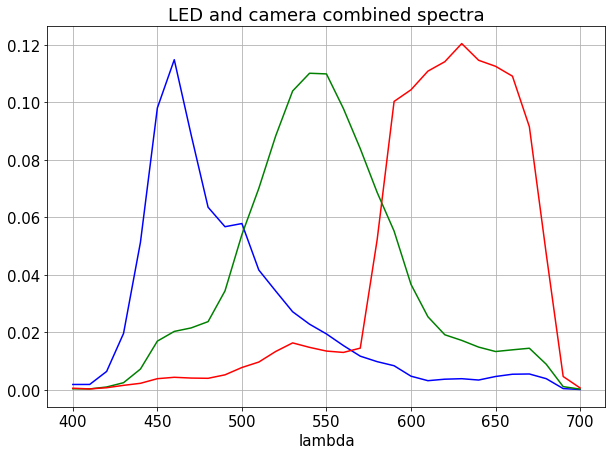

In [4]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
plt.plot(led_stats['lambda'], led_stats['Blue.1'], 'b')
plt.plot(led_stats['lambda'], led_stats['Green.1'], 'g')
plt.plot(led_stats['lambda'], led_stats['Red.1'], 'r')
plt.xlabel('lambda')
plt.title('LED and camera combined spectra')
plt.grid()

In [5]:
Ag_n = np.loadtxt('Ag_wu14.txt')
lamb_min = Ag_n[0,0]; lamb_max = Ag_n[-1,0]
m_ag = {}
m_ag['R'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,1], kind='cubic')
m_ag['I'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,2], kind='cubic')
#mask = (ag_n[:,0]>0.35) & (ag_n[:,0]<0.65)
#ag_mask = ag_n[mask]

In [6]:
lambda_set, lambda_weights = {}, {}
cols = ['Blue', 'Green', 'Red']
for col in cols:
    lam_peak = led_stats.loc[np.argmax(led_stats[col+'.1']==np.max(led_stats[col+'.1'])), 'lambda']
    weight_peak = led_stats.loc[np.argmax(led_stats[col+'.1']==np.max(led_stats[col+'.1'])), col+'.1']
    lam_left = led_stats.loc[np.argmax(led_stats[col+'.1']>np.max(led_stats[col+'.1'])-np.std(led_stats[col+'.1'])), 'lambda']
    weight_left = led_stats.loc[np.argmax(led_stats[col+'.1']>np.max(led_stats[col+'.1'])-np.std(led_stats[col+'.1'])), col+'.1']
    lam_right = led_stats.loc[np.argmax((led_stats[col+'.1']>np.max(led_stats[col+'.1'])-np.std(led_stats[col+'.1'])) * (led_stats['lambda']>lam_peak)), 'lambda']
    weight_right = led_stats.loc[np.argmax((led_stats[col+'.1']>np.max(led_stats[col+'.1'])-np.std(led_stats[col+'.1'])) * (led_stats['lambda']>lam_peak)), col+'.1']
    print(col,'\n\tpeak', lam_peak, '\n\tleft', lam_left, '\n\tright', lam_right)
    lambda_set[col] = [lam_left, lam_peak, lam_right]
    lambda_weights[col] = np.array([weight_left, weight_peak, weight_right])/weight_peak

Blue 
	peak 460 
	left 450 
	right 470
Green 
	peak 540 
	left 520 
	right 550
Red 
	peak 630 
	left 590 
	right 640


In [7]:
lambda_weights

{'Blue': array([0.85370015, 1.        , 0.7717951 ]),
 'Green': array([0.8021702 , 1.        , 0.99793079]),
 'Red': array([0.83280035, 1.        , 0.95170281])}

In [8]:
'B'.lower()

'b'

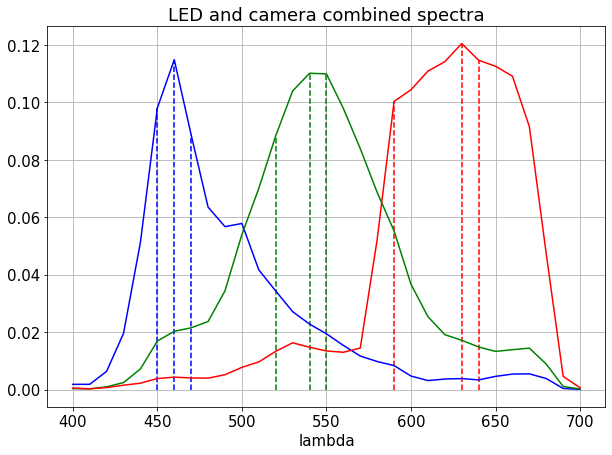

In [36]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,7))
# plt.plot(led_stats['lambda'], led_stats['Blue.1'], 'b')
# plt.plot(led_stats['lambda'], led_stats['Green.1'], 'g')
# plt.plot(led_stats['lambda'], led_stats['Red.1'], 'r')
for col in cols:
    plt.plot(led_stats['lambda'], led_stats[col+'.1'], col[0].lower())
    peak_height = np.max(led_stats[col+'.1'])
    for lam, weight in zip(lambda_set[col], lambda_weights[col]):
        plt.vlines(lam, 0, weight*peak_height, colors=[col[0].lower()], linestyles='dashed')
plt.xlabel('lambda')
plt.title('LED and camera combined spectra')
plt.grid()
plt.savefig('thesis/led_spectra.png')
plt.show()

In [ ]:
%%time
d = 40
detector = hp.detector_grid(100, .01)
len_dda = Lens(1.38, DDA(use_gpu=True, suppress_C_output=False))

holo_rgb = {}
for col in cols:
    holo_col = None
    for lam, weight in zip(lambda_set[col], lambda_weights[col]):
        lam *= 1e-3
        #ell = Ellipsoid(r = (0.1,0.05,0.05), n = m_ag['R'](lam)+1j*m_ag['I'](lam), center = (0.5,0.5,0))
        sph = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0.5,0.5,0))
        if holo_col is None:
            holo_col = newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
        else:
            holo_col += newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
    holo_rgb[col] = (holo_col/len(lambda_set[col])).copy()

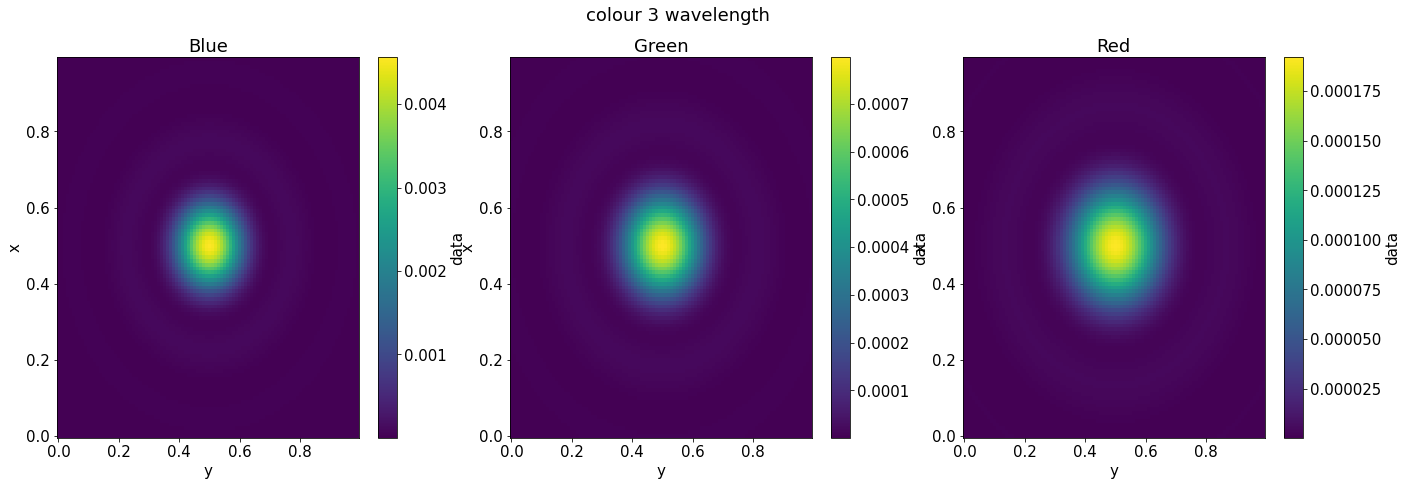

In [38]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 3, figsize=(23, 7))
axes = np.ravel(axes)
for i,col in enumerate(cols):
    newsdm_utils.get_unpol(holo_rgb[col]).plot(ax=axes[i])
    axes[i].set_title(col)
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('colour 3 wavelength')
plt.show()

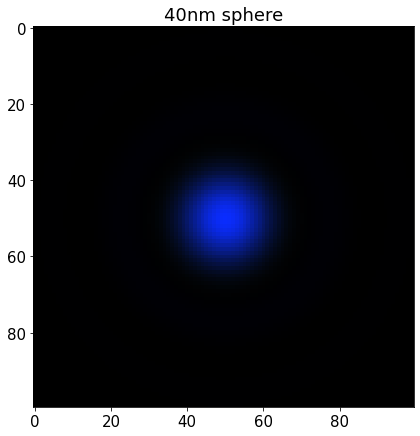

In [41]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(7,7))
img_rgb = np.concatenate([holo_rgb[col].sel(S='I').to_numpy() for col in ['Red','Green','Blue']], axis=2)
plt.imshow(img_rgb/np.max(img_rgb))
plt.title(str(d)+'nm sphere')
plt.savefig('thesis/col_'+str(d)+'sphere.png')
plt.show()

In [42]:
print('peak brightness', np.max(img_rgb))

peak brightness 0.004561915729766751


In [ ]:
%%time
d = 100
detector = hp.detector_grid(100, .01)
len_dda = Lens(1.38, DDA(use_gpu=True, suppress_C_output=False))

holo_rgb_100 = {}
for col in cols:
    holo_col = None
    for lam, weight in zip(lambda_set[col], lambda_weights[col]):
        lam *= 1e-3
        #ell = Ellipsoid(r = (0.1,0.05,0.05), n = m_ag['R'](lam)+1j*m_ag['I'](lam), center = (0.5,0.5,0))
        sph = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0.5,0.5,0))
        if holo_col is None:
            holo_col = newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
        else:
            holo_col += newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
    holo_rgb_100[col] = (holo_col/len(lambda_set[col])).copy()

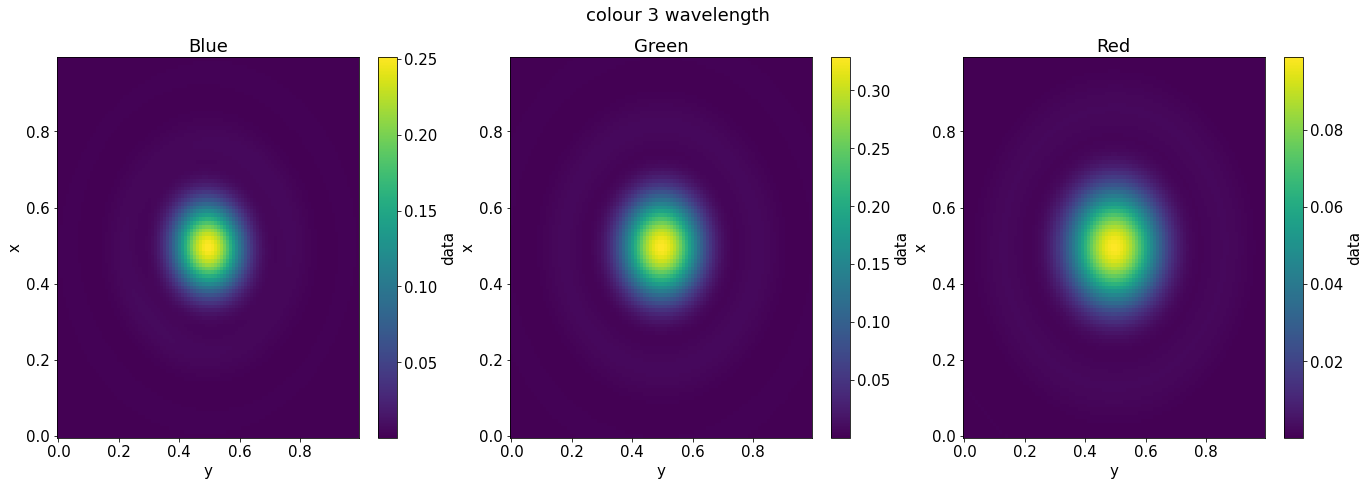

In [44]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 3, figsize=(23, 7))
axes = np.ravel(axes)
for i,col in enumerate(cols):
    newsdm_utils.get_unpol(holo_rgb_100[col]).plot(ax=axes[i])
    axes[i].set_title(col)
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('colour 3 wavelength')
plt.show()

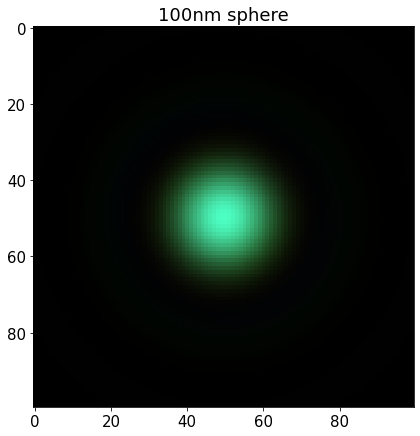

In [46]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(7,7))
img_rgb = np.concatenate([holo_rgb_100[col].sel(S='I').to_numpy() for col in ['Red','Green','Blue']], axis=2)
plt.imshow(img_rgb/np.max(img_rgb))
plt.title(str(d)+'nm sphere')
plt.savefig('thesis/col_'+str(d)+'sphere.png')
plt.show()

In [47]:
print('peak brightness', np.max(img_rgb))

peak brightness 0.3285358914912905


In [ ]:
%%time
d = 60
detector = hp.detector_grid(100, .01)
len_dda = Lens(1.38, DDA(use_gpu=True, suppress_C_output=False, max_dpl_size=0.001))

holo_rgb_100 = {}
for col in cols:
    holo_col = None
    for lam, weight in zip(lambda_set[col], lambda_weights[col]):
        lam *= 1e-3
        #ell = Ellipsoid(r = (0.1,0.05,0.05), n = m_ag['R'](lam)+1j*m_ag['I'](lam), center = (0.5,0.5,0))
        sph = Sphere(n = m_ag['R'](lam)+1j*m_ag['I'](lam), r = d/2*1e-3, center = (0.5,0.5,0))
        if holo_col is None:
            holo_col = newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
        else:
            holo_col += newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
    holo_rgb_100[col] = (holo_col/len(lambda_set[col])).copy()

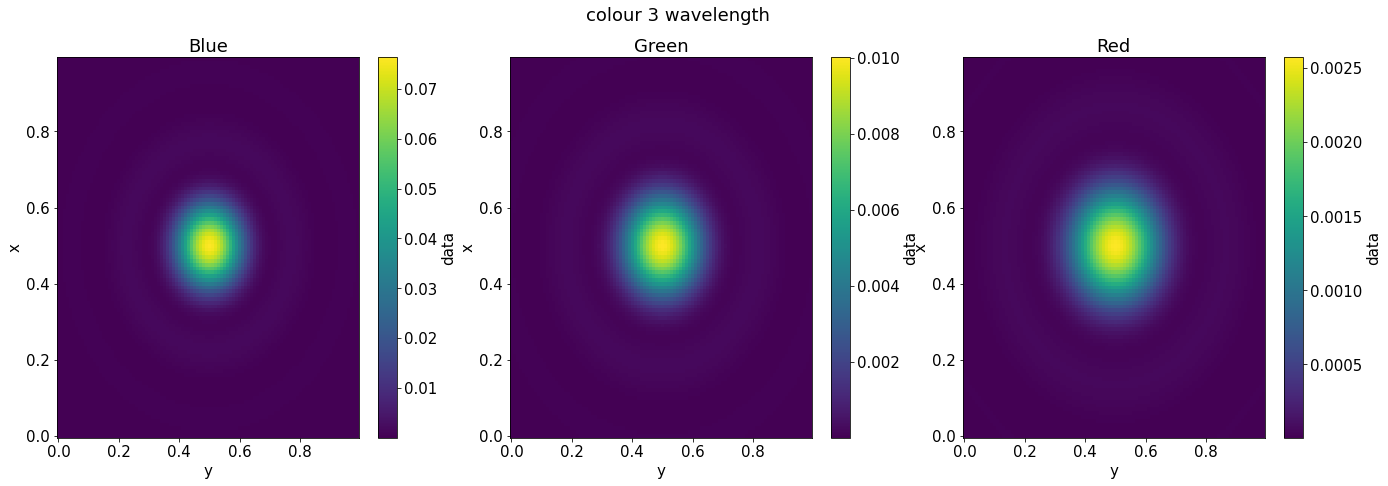

In [14]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, 3, figsize=(23, 7))
axes = np.ravel(axes)
for i,col in enumerate(cols):
    newsdm_utils.get_unpol(holo_rgb_100[col]).plot(ax=axes[i])
    axes[i].set_title(col)
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('colour 3 wavelength')
plt.show()

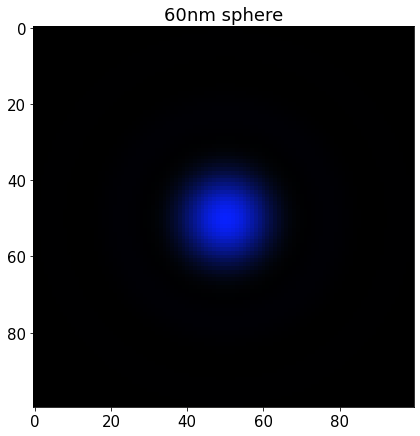

In [15]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(7,7))
img_rgb = np.concatenate([holo_rgb_100[col].sel(S='I').to_numpy() for col in ['Red','Green','Blue']], axis=2)
plt.imshow(img_rgb/np.max(img_rgb))
plt.title(str(d)+'nm sphere')
plt.savefig('thesis/col_'+str(d)+'sphere.png')
plt.show()

In [16]:
print('peak brightness', np.max(img_rgb))

peak brightness 0.07630607058761986


In [30]:
0.328/0.045

7.28888888888889

In [18]:
from holopy.scattering.theory import Mie

In [33]:
%%time
d = 60
detector = hp.detector_grid(100, .01)
len_dda = Lens(1.38, Mie())#DDA(use_gpu=True, suppress_C_output=False, max_dpl_size=0.001))

holo_rgb_100 = {}
for col in cols:
    holo_col = None
    for lam, weight in zip(lambda_set[col], lambda_weights[col]):
        lam *= 1e-3
        #ell = Ellipsoid(r = (0.1,0.05,0.05), n = m_ag['R'](lam)+1j*m_ag['I'](lam), center = (0.5,0.5,0))
        sph = Sphere(n = m_ag['R'](lam/1.33)+1j*m_ag['I'](lam/1.33), r = d/2*1e-3, center = (0.5,0.5,0))
        if holo_col is None:
            holo_col = newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
        else:
            holo_col += newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
    holo_rgb_100[col] = (holo_col/len(lambda_set[col])).copy()

CPU times: user 2min 40s, sys: 8.28 s, total: 2min 48s
Wall time: 36.9 s


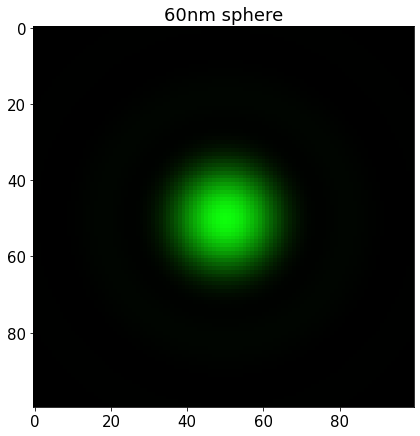

In [34]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(7,7))
img_rgb = np.concatenate([holo_rgb_100[col].sel(S='I').to_numpy() for col in ['Red','Green','Blue']], axis=2)
plt.imshow(img_rgb/np.max(img_rgb))
plt.title(str(d)+'nm sphere')
plt.savefig('thesis/col_'+str(d)+'sphere.png')
plt.show()

In [35]:
print('peak brightness', np.max(img_rgb))

peak brightness 0.16572807723566838


In [36]:
%%time
d = 100
detector = hp.detector_grid(100, .01)
len_dda = Lens(1.38, Mie())#DDA(use_gpu=True, suppress_C_output=False, max_dpl_size=0.001))

holo_rgb_100 = {}
for col in cols:
    holo_col = None
    for lam, weight in zip(lambda_set[col], lambda_weights[col]):
        lam *= 1e-3
        #ell = Ellipsoid(r = (0.1,0.05,0.05), n = m_ag['R'](lam)+1j*m_ag['I'](lam), center = (0.5,0.5,0))
        sph = Sphere(n = m_ag['R'](lam/1.33)+1j*m_ag['I'](lam/1.33), r = d/2*1e-3, center = (0.5,0.5,0))
        if holo_col is None:
            holo_col = newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
        else:
            holo_col += newsdm_utils.calc_unpolar(detector, scat=sph, medium_index=1.33, illum_wavelen=lam, theory=len_dda) * weight
    holo_rgb_100[col] = (holo_col/len(lambda_set[col])).copy()

CPU times: user 2min 40s, sys: 8.18 s, total: 2min 48s
Wall time: 37 s


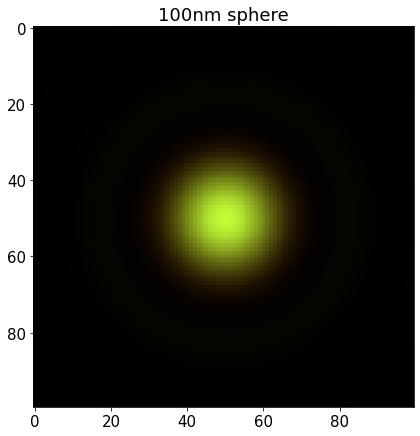

In [37]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(7,7))
img_rgb = np.concatenate([holo_rgb_100[col].sel(S='I').to_numpy() for col in ['Red','Green','Blue']], axis=2)
plt.imshow(img_rgb/np.max(img_rgb))
plt.title(str(d)+'nm sphere')
plt.savefig('thesis/col_'+str(d)+'sphere.png')
plt.show()

In [38]:
print('peak brightness', np.max(img_rgb))

peak brightness 0.3407658328556023
